<h2><i><b>Analysis of CODE1</b></i></h2>
<I>

---


**Target:**

*   Basic code setup with Data Loaders / Sample Architecture / Predictions + Validation
*   No check of parameters or augumenters taken care at this step


**Results:**<br>

*   Epochs - 15
*   Parameters - 6.3M
*   Best Train Acc -  99.97(14th epoch)
*   Best Test Acc  - 99.41(11th epoch)
*   Train/Test Acc last layer - 99.96/99.27 (Difference - 0.70)


**Analysis:**<br>


*   Training logs shows sign of overfitting.
*   The model is large in terms of capacity(parameter count) making it more complex.
*   Since there are no transforms being done trained model becomes biased to train images which might not be actual representation of true conditions.


---


**MODEL Receptive Field Calculation**

```
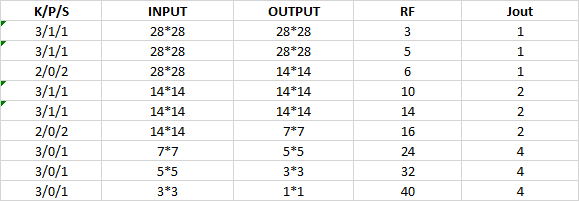

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


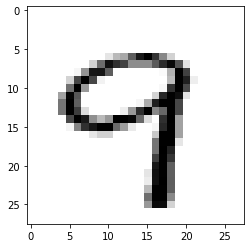

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

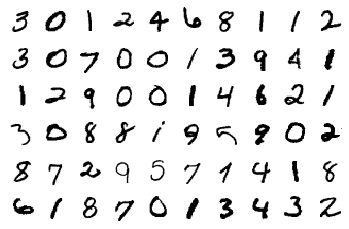

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [0]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
      def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.conv6 = nn.Conv2d(512, 1024, 3)
        self.conv7 = nn.Conv2d(1024, 10, 3)

      def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**Input/Output and RF calculation**


```
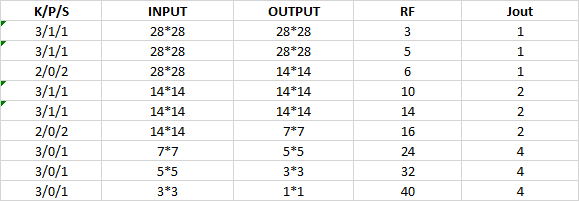

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.04587279260158539 Batch_id=937 Accuracy=89.18: 100%|██████████| 938/938 [00:16<00:00, 57.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.016826823353767395 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:16<00:00, 57.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.0013469457626342773 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:16<00:00, 58.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.014082282781600952 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:15<00:00, 58.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.00011807680130004883 Batch_id=937 Accuracy=99.58: 100%|██████████| 938/938 [00:16<00:00, 57.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.0007361769676208496 Batch_id=937 Accuracy=99.63: 100%|██████████| 938/938 [00:15<00:00, 58.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.004653245210647583 Batch_id=937 Accuracy=99.70: 100%|██████████| 938/938 [00:15<00:00, 62.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.039608508348464966 Batch_id=937 Accuracy=99.83: 100%|██████████| 938/938 [00:15<00:00, 58.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.0009067654609680176 Batch_id=937 Accuracy=99.78: 100%|██████████| 938/938 [00:16<00:00, 57.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.0022322535514831543 Batch_id=937 Accuracy=99.88: 100%|██████████| 938/938 [00:16<00:00, 57.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.0007526278495788574 Batch_id=937 Accuracy=99.89: 100%|██████████| 938/938 [00:16<00:00, 58.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=3.6954879760742188e-06 Batch_id=937 Accuracy=99.95: 100%|██████████| 938/938 [00:16<00:00, 57.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=1.5228986740112305e-05 Batch_id=937 Accuracy=99.94: 100%|██████████| 938/938 [00:16<00:00, 58.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=3.606081008911133e-06 Batch_id=937 Accuracy=99.97: 100%|██████████| 938/938 [00:16<00:00, 58.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.0021448135375976562 Batch_id=937 Accuracy=99.96: 100%|██████████| 938/938 [00:16<00:00, 58.17it/s]



Test set: Average loss: 0.0307, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

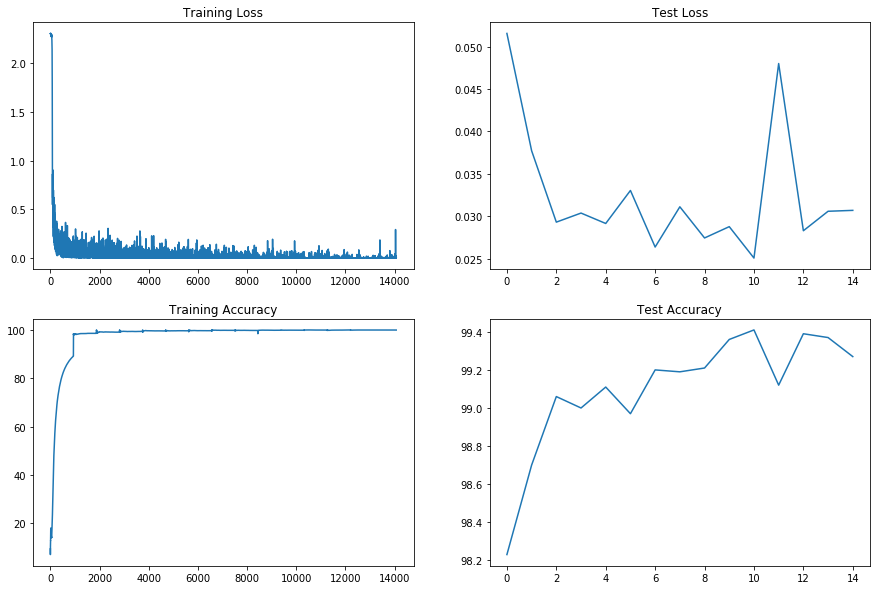

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")